In [1]:
# Initialization

import math
from datetime import datetime
import openpyxl as opxl
from openpyxl.utils.dataframe import dataframe_to_rows
import pandas as pd
import numpy as np
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go

import sklearn.metrics
import scipy.integrate as integrate
import scipy.optimize as sco

import fluids as fds
import ht 

import general as gen
import model as ty
import proc as pr
import heat_transfer as bht
import plot_functions as pfun
# importing sys
import sys
sys.path.insert(0,r'C:\Users\valen\Dropbox (DualSun)\PC\Documents\GitHub\RD-systems-and-test-benches')
import SK_standard as sk

import networkx as nx

In [3]:
input_name = r'\Inputs_V4.41-NI-glass-backsheet.xlsx'
data_name = r'\230104_TUV_test_conditions_V4.41_dark_nowind.xlsx'

par = pr.import_input(r'G:\Drive partagés\BU04-Innovation\PVT-perf-1Dmodel\Inputs',input_name)
hyp = pr.create_dict_from_excel(r'G:\Drive partagés\BU04-Innovation\PVT-perf-1Dmodel\Hypotheses','\Model_hypotheses.xlsx','Main')
condi = pr.create_inputs_from_excel(r'G:\Drive partagés\BU04-Innovation\PVT-perf-1Dmodel\Steady-state conditions inputs'+data_name,par,hyp)

{'exchanger': {'name': 'xxx', 'eta_nom': 0.201, 'Eff_T': -0.0034000000000000002, 'T_ref': 298.15, 'Eff_G': 0, 'G_ref': 1000, 'X_corr': 1, 'tau_alpha': 0.8, 'eps': 0.95, 'eps_bs': 1, 'w_pan': 1.134, 'L_pan': 1.708, 'orientation': 'portrait', 'lambd_upper_glass': 0.00278, 'lambd_upper_EVA': 0.000515, 'lambd_si': 0.00015, 'lambd_lower_EVA': 0.000515, 'lambd_PVDF': 2.9999999999999997e-05, 'lambd_PET': 0.00027, 'lambd_adh': 0.0, 'lambd_lower_glass': 0.0, 'k_glass': 0.8, 'k_EVA': 0.24, 'k_si': 60, 'k_PVDF': 0.2, 'k_PET': 0.3, 'k_adh': 0.2, 'L_abs': 1.342, 'w_abs': 0.976, 'geometry': 'harp', 'N_harp': 300, 'N_meander': 1, 'L_tube': 1.342, 'tube_geometry': 'rectangular', 'H_tube': 0.002, 'w_tube': 0.00281, 'W': 0.00335, 'l_c': 0.003, 'p_ext_tube': 0.00335, 'p_ext_tube_rad': 0.0, 'lambd_air': 0.0, 'lambd_conductive_plate': 0.0, 'lambd_abs': 0.00035, 'lambd_riser_plate': 0.0, 'lambd_riser_back': 0.00035, 'lambd_ins': 0.0, 'eps_he': 0.2, 'eps_ins': 0.8, 'k_air': 0.025, 'k_conductive_plate': 1, 'k

In [ ]:
df_res,X,list_res,list_df,list_df_historic = ty.simu_condi(par,hyp,condi)

In [16]:
pr.disp_html(df_res)

,G,-(T_m - T_a),-(T_m - T_a)^2,-up x (T_m - T_a),Gp,dT_m/dt,up x G,up x Gp,-(T_m - T_a)^4,mdot,T_amb,u,h_top,h_back,h_rad_back,h_back_tube,h_rad_back_tube,h_back_fins,h_rad_f,h_fluid,T_PV,T_fluid_in,T_tube_mean,h_rad,X_celltemp,eta_PV,S,T_fluid_out,T_fluid_mean,T_Base_mean,T_absfin_mean,T_abs_mean,Q_absfin_back,T_ins_tube_mean,T_ins_absfin_mean,T_ins_mean,T_PV_Base_mean,T_PV_absfin_mean,Q_top_conv,Q_top_rad,Q_PV_plate,Q_PV_Base,Q_PV_absfin,Q_tube_fluid,Q_Base_tube,Q_absfins_Base,Q_tube_back_conv,Q_tube_back_rad,Q_ins_tube_back_conv,Q_ins_tube_back_rad,Q_ins_absfin_back_conv,Q_ins_absfin_back_rad,Q_S,DT,T_m,T_m en °C,Cp(T),Qdot,Qdot / AG,-Q_top_conv,-Q_top_rad,-Q_ins_absfin_back_conv,-Q_ins_absfin_back_rad,-Q_tube_back_conv,-Q_tube_back_rad
0,0.001,8.747066,0.0,-23.617077,0.0,0.0,0.0027,10.8,-5853.957101,0.04970,296.169,0.3,3.967302,4.531315,1.137313,4.531315,1.127959,4.531315,0.0,286.449195,289.353549,286.945,287.551677,5.407756,1.029908,0.207011,0.000634,287.898869,287.402943,289.151242,289.151268,289.151272,-6.941384,287.551677,289.151268,347.638301,289.353520,289.353679,-43.676024,-59.979797,103.656861,92.826333,10.838845,198.740372,110.598499,17.772166,-69.917489,-18.217327,-69.917489,-18.217327,-5.584550,-1.356834,0.000035,0.953869,287.421934,14.271934,4190.626810,198.666214,102.570647,43.676024,59.979797,5.584550,1.356834,69.917489,18.217327
1,0.001,8.589854,0.0,-23.192605,0.0,0.0,0.0027,10.8,-5444.312718,0.04962,295.990,0.3,3.965302,4.512556,1.135951,4.512556,1.126772,4.512556,0.0,285.972905,289.296782,286.932,287.527462,5.401179,1.030101,0.207050,0.000634,287.868293,287.381462,289.098275,289.098300,289.098305,-6.792479,287.527462,289.098300,347.581542,289.296753,289.296911,-42.868003,-58.840337,101.709380,91.082334,10.635361,194.765473,108.502111,17.419778,-68.379934,-17.871316,-68.379934,-17.871316,-5.461424,-1.331055,0.000035,0.936293,287.400146,14.250146,4190.653501,194.692907,100.519243,42.868003,58.840337,5.461424,1.331055,68.379934,17.871316
2,0.001,8.595519,0.0,-23.207900,0.0,0.0,0.0027,10.8,-5458.688745,0.04961,295.957,0.3,3.965410,4.513844,1.135541,4.513844,1.126359,4.513844,0.0,285.646756,289.259468,286.893,287.489029,5.399235,1.030228,0.207076,0.000634,287.829963,287.342783,289.060874,289.060898,289.060903,-6.797514,287.489029,289.060898,347.536256,289.259440,289.259598,-42.896930,-58.856723,101.754693,91.122914,10.640093,194.867620,108.552462,17.429546,-68.452274,-17.876276,-68.452274,-17.876276,-5.466097,-1.331417,0.000035,0.936963,287.361481,14.211481,4190.700963,194.795211,100.572062,42.896930,58.856723,5.466097,1.331417,68.452274,17.876276
3,0.001,8.696511,0.0,-23.480578,0.0,0.0,0.0027,10.8,-5719.790298,0.04962,296.052,0.3,3.966711,4.526055,1.136184,4.526055,1.126890,4.526055,0.0,285.616138,289.276106,286.881,287.484763,5.402356,1.030171,0.207064,0.000634,287.829979,287.336595,289.075099,289.075125,289.075129,-6.892808,287.484763,289.075125,347.548835,289.276078,289.276236,-43.415096,-59.574614,102.990750,92.229822,10.769243,197.406804,109.883814,17.653990,-69.440207,-18.094390,-69.440207,-18.094390,-5.545154,-1.347654,0.000035,0.948979,287.355489,14.205489,4190.708330,197.333482,101.882562,43.415096,59.574614,5.545154,1.347654,69.440207,18.094390
4,0.001,1.262527,0.0,-3.408824,0.0,0.0,0.0027,10.8,-2.540757,0.05144,295.963,0.3,3.867923,3.287548,1.169883,3.287548,1.168512,3.287548,0.0,352.942252,294.973264,294.640,294.713048,5.557774,1.010801,0.203171,0.000637,294.760945,294.697241,294.943729,294.943732,294.943748,-0.791220,294.713048,294.943732,354.943465,294.973246,294.973386,-6.114443,-9.010336,15.125824,13.545556,1.588758,26.038832,15.917302,2.371744,-7.388522,-2.736189,-7.388522,-2.736189,-0.587155,-0.204065,0.000035,0.120945,294.700473,21.550473,4183.679963,26.028494,13.438417,6.114443,9.010336,0.587155,0.204065,7.388522,2.736189
5,0.001,1.071907,0.0,-2.894149,0.0,0.0,0.0027,10.8,-1.320165,0.05145,295.782,0.3,3.863428,3.242888,1.168645,3.242888,1.167482,3.242888,0.0,353.133842,294.941580,294.659,29

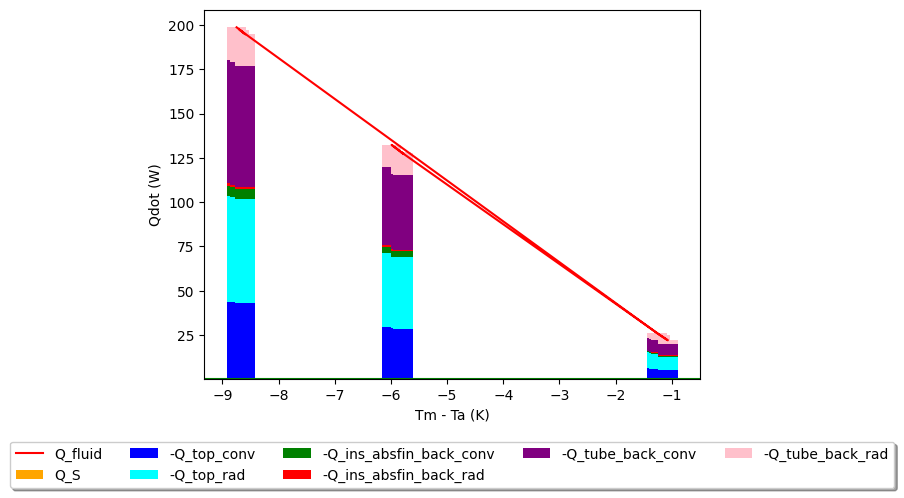

In [13]:
u_list = df_res['u'].unique()

# powers = ["Q_S","Q_top_conv","Q_top_rad","Q_tube_back_conv","Q_tube_back_rad","Q_f01"]
df_res["-Q_top_conv"] = -df_res["Q_top_conv"]
df_res["-Q_top_rad"] = -df_res["Q_top_rad"]
df_res["-Q_ins_absfin_back_conv"] = -df_res["Q_ins_absfin_back_conv"]
df_res["-Q_ins_absfin_back_rad"] = -df_res["Q_ins_absfin_back_rad"]
df_res["-Q_tube_back_conv"] = -df_res["Q_tube_back_conv"]
df_res["-Q_tube_back_rad"] = -df_res["Q_tube_back_rad"]
# df_res["-Q_f01"] = -df_res["Q_f01"]

df_select_u = df_res.loc[df_res["u"]==u_list[0]]

powers = ["Q_S","-Q_top_conv","-Q_top_rad","-Q_ins_absfin_back_conv","-Q_ins_absfin_back_rad","-Q_tube_back_conv","-Q_tube_back_rad"]

df_hist = df_select_u

dict_pos = {}
dict_neg = {}
dict_pos_agg = {}
dict_neg_agg = {}

DT_list = []
for DT in df_hist["-(T_m - T_a)"]:
    DT_list.append(-DT)

# powers = ["S_loc","-Q_top_conv","-Q_top_rad","-Q_tube_back"]
# powers = ["S_loc","-Q_top_conv","-Q_top_rad","-Q_fluid_back","-Q_f01"]


for i in range(len(powers)):
    str = powers[i]
    
    dict_pos[str] = np.array(ty.pos_df(df_hist,str))
    dict_neg[str] = np.array(ty.neg_df(df_hist,str))

    if i==0:
        dict_pos_agg[str] = 0*np.array(ty.pos_df(df_hist,str))
        dict_neg_agg[str] = dict_pos_agg[str]

    else:
        dict_pos_agg[str] = dict_pos_agg[powers[i-1]] + dict_pos[powers[i-1]]
        dict_neg_agg[str] = dict_neg_agg[powers[i-1]] + dict_neg[powers[i-1]]

fig, ax = plt.subplots()

width = 0.35

# labels_list = ['Sun','Front convection','Front radiation','Back convection and radiation']
labels_list = powers
colors_list = ['orange','blue','cyan','green','red','purple','pink']

for i,str in enumerate(powers):
    ax.bar(DT_list, dict_pos[str], width, bottom=dict_pos_agg[str], label=labels_list[i], color=colors_list[i])
    ax.bar(DT_list, dict_neg[str], width, bottom=dict_neg_agg[str], color=colors_list[i])

ax.plot(DT_list,df_hist["Q_tube_fluid"],color="red",label="Q_fluid")
# ax.plot(labels,np.array(N_disp*[list_PL[q]]))

# ax.set_ylabel('PL (Pa)')
# ax.set_title('SPRING')
ax.set_xlabel("Tm - Ta (K)")
ax.set_ylabel("Qdot (W)")
ax.axhline(y = 0., color = 'g', linestyle = '-')
  
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [ ]:
color_list = ['blue','red','green','orange','cyan','purple']

popt_mod_list,pcov_mod_list,popt_tuv_list,pcov_tuv_list = pr.linear_interpolation(u_list,df_res,condi)

pfun.plot_model_tuv(u_list,df_res,condi,popt_mod_list,popt_tuv_list,color_list)

In [6]:
pr.disp_html(df_res)

,G,-(T_m - T_a),-(T_m - T_a)^2,-up x (T_m - T_a),Gp,dT_m/dt,up x G,up x Gp,-(T_m - T_a)^4,mdot,T_amb,u,h_top,h_back,h_rad_back,h_back_tube,h_rad_back_tube,h_back_fins,h_rad_f,h_fluid,T_PV,T_fluid_in,T_tube_mean,h_rad,X_celltemp,eta_PV,S,T_fluid_out,T_fluid_mean,T_Base_mean,T_absfin_mean,T_abs_mean,Q_absfin_back,T_ins_tube_mean,T_ins_absfin_mean,T_ins_mean,T_PV_Base_mean,T_PV_absfin_mean,Q_top_conv,Q_top_rad,Q_PV_plate,Q_PV_Base,Q_PV_absfin,Q_tube_fluid,Q_Base_tube,Q_absfins_Base,Q_tube_back_conv,Q_tube_back_rad,Q_ins_tube_back_conv,Q_ins_tube_back_rad,Q_ins_absfin_back_conv,Q_ins_absfin_back_rad,Q_S,DT,T_m,T_m en °C,Cp(T),Qdot,Qdot / AG
0,0.001,8.747066,0.0,-23.617077,0.0,0.0,0.0027,10.8,-5853.957101,0.04970,296.169,0.3,3.967302,4.531315,1.137313,4.531315,1.127959,4.531315,0.0,286.449195,289.353549,286.945,287.551677,5.407756,1.029908,0.207011,0.000634,287.898869,287.402943,289.151242,289.151268,289.151272,-6.941384,287.551677,289.151268,347.638301,289.353520,289.353679,-43.676024,-59.979797,103.656861,92.826333,10.838845,198.740372,110.598499,17.772166,-69.917489,-18.217327,-69.917489,-18.217327,-5.584550,-1.356834,0.000035,0.953869,287.421934,14.271934,4190.626810,198.666214,102.570647
1,0.001,8.589854,0.0,-23.192605,0.0,0.0,0.0027,10.8,-5444.312718,0.04962,295.990,0.3,3.965302,4.512556,1.135951,4.512556,1.126772,4.512556,0.0,285.972905,289.296782,286.932,287.527462,5.401179,1.030101,0.207050,0.000634,287.868293,287.381462,289.098275,289.098300,289.098305,-6.792479,287.527462,289.098300,347.581542,289.296753,289.296911,-42.868003,-58.840337,101.709380,91.082334,10.635361,194.765473,108.502111,17.419778,-68.379934,-17.871316,-68.379934,-17.871316,-5.461424,-1.331055,0.000035,0.936293,287.400146,14.250146,4190.653501,194.692907,100.519243
2,0.001,8.595519,0.0,-23.207900,0.0,0.0,0.0027,10.8,-5458.688745,0.04961,295.957,0.3,3.965410,4.513844,1.135541,4.513844,1.126359,4.513844,0.0,285.646756,289.259468,286.893,287.489029,5.399235,1.030228,0.207076,0.000634,287.829963,287.342783,289.060874,289.060898,289.060903,-6.797514,287.489029,289.060898,347.536256,289.259440,289.259598,-42.896930,-58.856723,101.754693,91.122914,10.640093,194.867620,108.552462,17.429546,-68.452274,-17.876276,-68.452274,-17.876276,-5.466097,-1.331417,0.000035,0.936963,287.361481,14.211481,4190.700963,194.795211,100.572062
3,0.001,8.696511,0.0,-23.480578,0.0,0.0,0.0027,10.8,-5719.790298,0.04962,296.052,0.3,3.966711,4.526055,1.136184,4.526055,1.126890,4.526055,0.0,285.616138,289.276106,286.881,287.484763,5.402356,1.030171,0.207064,0.000634,287.829979,287.336595,289.075099,289.075125,289.075129,-6.892808,287.484763,289.075125,347.548835,289.276078,289.276236,-43.415096,-59.574614,102.990750,92.229822,10.769243,197.406804,109.883814,17.653990,-69.440207,-18.094390,-69.440207,-18.094390,-5.545154,-1.347654,0.000035,0.948979,287.355489,14.205489,4190.708330,197.333482,101.882562
4,0.001,1.262527,0.0,-3.408824,0.0,0.0,0.0027,10.8,-2.540757,0.05144,295.963,0.3,3.867923,3.287548,1.169883,3.287548,1.168512,3.287548,0.0,352.942252,294.973264,294.640,294.713048,5.557774,1.010801,0.203171,0.000637,294.760945,294.697241,294.943729,294.943732,294.943748,-0.791220,294.713048,294.943732,354.943465,294.973246,294.973386,-6.114443,-9.010336,15.125824,13.545556,1.588758,26.038832,15.917302,2.371744,-7.388522,-2.736189,-7.388522,-2.736189,-0.587155,-0.204065,0.000035,0.120945,294.700473,21.550473,4183.679963,26.028494,13.438417
5,0.001,1.071907,0.0,-2.894149,0.0,0.0,0.0027,10.8,-1.320165,0.05145,295.782,0.3,3.863428,3.242888,1.168645,3.242888,1.167482,3.242888,0.0,353.133842,294.941580,294.659,294.720690,5.551767,1.010909,0.203193,0.000637,294.761186,294.707340,294.916525,294.916527,294.916543,-0.664840,294.720690,294.916527,354.919033,294.941562,294.941702,-5.185024,-7.643983,12.830052,11.489661,1.348880,22.004283,13.495150,2.005487,-6.189647,-2.321164,-6.189647,-2.321164,-0.491723,-0.173118,0.000035,0.102186,294.710093,21.560093,4183.673119,21.995549,11.356222
6,0.001,1.204446,

In [ ]:
[tab,X] = sk.find_SK_SST(condi,par['A_G'],columns_list=[0,1,0,0,0,0,0,0,0])
[tab_m,X_m] = sk.find_SK_SST(df_res,par['A_G'],columns_list=[0,1,0,0,0,0,0,0,0])

In [ ]:
X_df = pd.DataFrame(X[0],index = ['eta0,hem','a1','a2','a3','a4','a5','a6','a7','a8'],columns=['TÜV'])

In [ ]:
X_df['Model'] = X_m[0]

In [ ]:
X_df = pd.concat(X_df,)

In [ ]:
X_df = X_df.T

In [ ]:
X_df

In [ ]:
X_df[0].name = 'Model'

In [ ]:
X_df

In [ ]:
mse = sklearn.metrics.mean_squared_error(df_res['Q_dot / A_G'],condi['Q_dot / A_G'])
print(math.sqrt(mse))